# 5 次元削減でデータを圧縮する

特徴部分空間(feature extraction)を作成する

- 主成分分析(PCA: PrincipalComponent Analysis)
- 線形判別分析(LDA: Linear Discriminant Analysis)
- カーネル主成分分析

## 5.1 主成分分析による教師なし次元削減

1. d次元のデータセットを標準化する
2. 標準化したデータセットの共分散行列(covariance matric)を作成する
3. 共分散行列を固有ベクトルと固有値に分解する
4. 最も大きいk個の固有値に対するk個の固有ベクトルを選択する
5. 上位k個の固有ベクトルから射影行列Wを作成する
6. 射影行列Wを使ってd次元の入力データセットXを変換し、新しいk次元の特徴部分空間を取得する

### 5.1.1 共分散行列の固有対を求める

In [1]:
from IPython.core.display import display
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

import pandas as pd
# http://archive.ics.uci.edu/ml/datasets/Wine
df_wine = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

# 1. d次元のデータセットを標準化する

if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# 特徴量とクラスラベルを別々に抽出
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
# 全体の30%をテストデータにする
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [2]:
import numpy as np
# 2. 共分散行列を作成
cov_mat = np.cov(X_train_std.T)
# 3. 固有値と固有ベクトルを計算
# linalg.eig関数は固有分解(eigendecomposition)を実行する関数
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
eigen_vals

array([ 4.8923083 ,  2.46635032,  1.42809973,  1.01233462,  0.84906459,
        0.60181514,  0.52251546,  0.08414846,  0.33051429,  0.29595018,
        0.16831254,  0.21432212,  0.2399553 ])

'var_exp:'

[0.37329647723490672,
 0.18818926106599568,
 0.10896790724757802,
 0.07724389477124842,
 0.064785946018261847,
 0.045920138114781427,
 0.039869355976347116,
 0.025219142607261595,
 0.02258180681767968,
 0.018309244719526909,
 0.016353362655051471,
 0.012842705837492762,
 0.006420756933868301]

'cum_var_exp:'

array([ 0.37329648,  0.56148574,  0.67045365,  0.74769754,  0.81248349,
        0.85840362,  0.89827298,  0.92349212,  0.94607393,  0.96438317,
        0.98073654,  0.99357924,  1.        ])

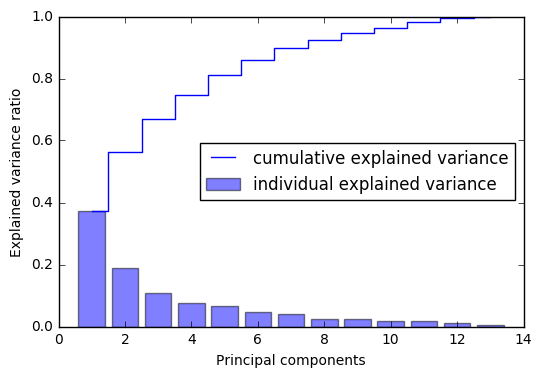

In [3]:
# 固有値を合計
tot = sum(eigen_vals)
# 分散説明率を計算
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
display("var_exp:", var_exp)
# 分散説明率の累積和を取得
cum_var_exp = np.cumsum(var_exp)
display("cum_var_exp:", cum_var_exp)

import matplotlib.pyplot as plt
# 分散説明率の棒グラフを作成
plt.bar(range(1, 14), var_exp, alpha=0.5, align='center', label='individual explained variance')
# 分散説明率の累積和の階段グラフを作成
plt.step(range(1, 14), cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

### 5.1.2 特徴変換

In [4]:
# (固有値, 固有ベクトル)のタプルのリストを作成
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
# (固有値, 固有ベクトル)のタプルを大きいものから順に並び替え
eigen_pairs.sort(reverse=True)

In [5]:
# 4. 最も大きいk個の固有値に対するk個の固有ベクトルを選択する(ここでは k = 2 とする)
# 5. 上位k個の固有ベクトルから射影行列Wを作成する
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
display("Matrix W:", w)

'Matrix W:'

array([[ 0.14669811,  0.50417079],
       [-0.24224554,  0.24216889],
       [-0.02993442,  0.28698484],
       [-0.25519002, -0.06468718],
       [ 0.12079772,  0.22995385],
       [ 0.38934455,  0.09363991],
       [ 0.42326486,  0.01088622],
       [-0.30634956,  0.01870216],
       [ 0.30572219,  0.03040352],
       [-0.09869191,  0.54527081],
       [ 0.30032535, -0.27924322],
       [ 0.36821154, -0.174365  ],
       [ 0.29259713,  0.36315461]])

In [6]:
# x' = xW
display(X_train_std[0].dot(w))

# 6. 射影行列Wを使ってd次元の入力データセットXを変換し、新しいk次元の特徴部分空間を取得する
# X' = XW
X_train_pca = X_train_std.dot(w)

array([ 2.59891628,  0.00484089])

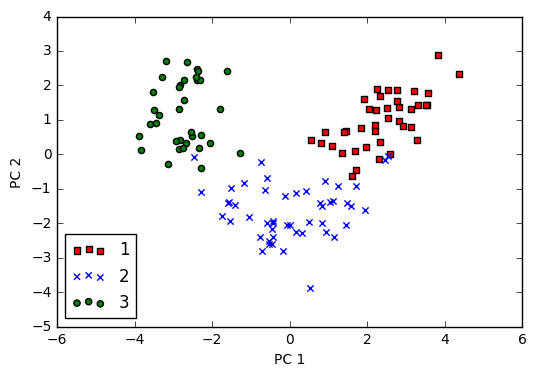

In [7]:
# 2次元の散布図としてプロット
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
# クラスラベル、点の色、点の種類の組み合わせからなるリストを生成してプロット
for label, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==label, 0], X_train_pca[y_train==label, 1], c=c, label=label, marker=m)
    
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

### 5.1.3 scikit-learn の主成分分析

In [8]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    # マーカーとカラーマップの用意
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 決定領域のプロット
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # グリッドポイントの生成
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    # 各特徴量を1次元配列に変換して予測を実行
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    # 予測結果を元のグリッドポイントのデータサイズに変換
    Z = Z.reshape(xx1.shape)
    # グリッドポイントの等高線のプロット
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    # 軸の範囲の設定
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # クラスごとにサンプルをプロット
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0], y=X[y==cl, 1], alpha=0.8, c=cmap(idx), marker=markers[idx], label=cl)
    

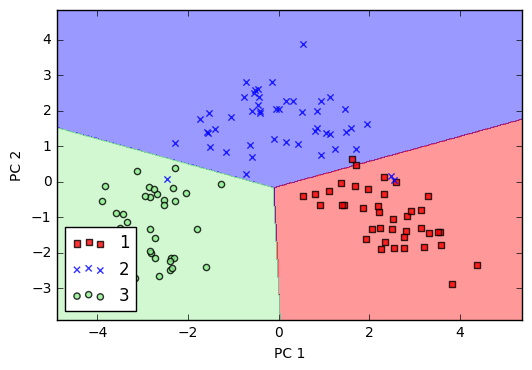

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
# 主成分数を指定して、PCAのインスタンスを生成
pca = PCA(n_components=2)
# ロジスティック回帰のインスタンスを生成
lr = LogisticRegression()
# トレーニングデータやテストデータをPCAに適合させる
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
# トレーニングデータをロジスティック回帰に適合させる
lr.fit(X_train_pca, y_train)
# 決定境界をプロット
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

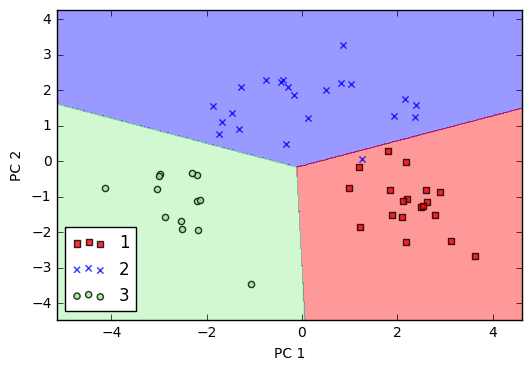

In [10]:
# 決定境界をプロット
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

In [11]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
# 分散説明率を計算
pca.explained_variance_ratio_

array([ 0.37329648,  0.18818926,  0.10896791,  0.07724389,  0.06478595,
        0.04592014,  0.03986936,  0.02521914,  0.02258181,  0.01830924,
        0.01635336,  0.01284271,  0.00642076])

## 5.2 線形判別分析による教師ありデータ圧縮

1. d次元のデータセットを標準化する(dは特徴量の個数)
2. クラスごとにd次元の平均ベクトルを計算する
3. クラス間変動行列SBと、クラス内変動行列SWを生成する
4. 行列 SW^-1 SB の固有ベクトルと対応する固有値を計算する
5. d x k次元の変換行列Wを生成するために、最も大きいk個の固有値に対応するk個の固有ベクトルを選択する
6. 変換行列Wを使ってサンプルを新しい特徴部分空間へ射影する

### 5.2.1 変動行列を計算する

- クラス内変動行列(within-class scatter matrix)
- クラス間変動行列(between-class scatter matrix)

In [12]:
# 1. d次元のデータセットを標準化する(dは特徴量の個数)
# X_train_std, X_test_std は作成済

# 2. クラスごとにd次元の平均ベクトルを計算する
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print('MV {}:, {}\n'.format(label, mean_vecs[label - 1]))


MV 1:, [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]

MV 2:, [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]

MV 3:, [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]



In [13]:
# 3. クラス間変動行列SBと、クラス内変動行列SWを生成する
d = 13 # 特徴量の個数
# クラス内変動行列 SW
S_W = np.zeros((d, d)) # 13 x 13 で値がすべて0の行列を生成
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    
    S_W += class_scatter
    
print('Within-class scatter matrix: {}x{}'.format(S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


In [14]:
# クラスラベルの一様に分散していない
print('Class label distribution: {}'.format(np.bincount(y_train)[1:]))

Class label distribution: [40 49 35]


In [15]:
d = 13
# クラス内変動行列 SW
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter

print('Scaled within-class scatter matrix: {}x{}'.format(S_W.shape[0], S_W.shape[1]))

Scaled within-class scatter matrix: 13x13


In [16]:
# クラス間変動行列SB
mean_overall = np.mean(X_train_std, axis=0)
d = 13
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train==i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: {}x{}'.format(S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


### 5.2.2 新しい特徴部分空間の線形判別を選択する

In [17]:
X_train[y_train==2, :].shape[0]

49

In [18]:
# 4. 行列 SW^-1 SB の固有ベクトルと対応する固有値を計算する
# inv関数で逆行列、dot関数で行列積、eig関数で固有値を計算
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [19]:
# (固有値, 固有ベクトル)のタプルのリストを作成
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
# (固有値, 固有ベクトル)のタプルを大きいものから順に並び替え
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
for eigen_val in eigen_pairs:
    print(eigen_val[0])

452.721581245
156.43636122
7.20678700076e-14
3.94081990073e-14
3.94081990073e-14
2.51053275902e-14
2.46878288879e-14
2.46878288879e-14
1.97651922798e-14
5.31966277392e-15
3.27314649699e-15
2.7136147327e-15
0.0


'discr:'

[0.74319244597448442,
 0.25680755402551542,
 1.1830736330233406e-16,
 4.1213166307355906e-17,
 1.6398103755690973e-17,
 1.6398103755690973e-17,
 8.7328136154577227e-18,
 4.4546981062384851e-18,
 0.0,
 -5.3732312571412594e-18,
 -3.2446744763511281e-17,
 -4.4506846796671235e-17,
 -4.4506846796671235e-17]

'cum_discr:'

array([ 0.7432,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,
        1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ])

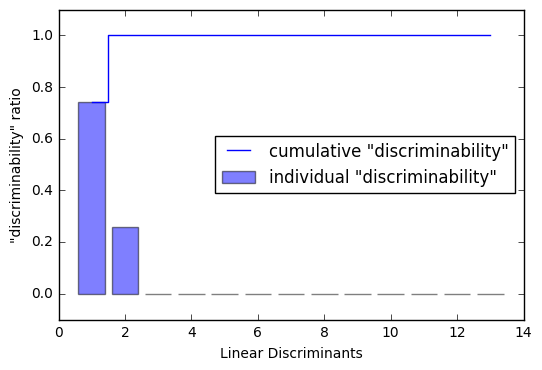

In [20]:
# 固有値の実数部の総和を求める
tot = sum(eigen_vals.real)
# 分散説明率とその累積和を計算
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
display("discr:", discr)
cum_discr = np.cumsum(discr)
display("cum_discr:", cum_discr)

# 分散説明率の棒グラフを作成
plt.bar(range(1, 14), discr, alpha=0.5, align='center', label='individual "discriminability"')
# 分散説明率の累積和の階段グラフを作成
plt.step(range(1, 14), cum_discr, where='mid', label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.show()

In [21]:
# 6. 変換行列Wを使ってサンプルを新しい特徴部分空間へ射影する
# 2つの固有ベクトルから変換行列を作成
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))
display("Matrix W:", w)

'Matrix W:'

array([[-0.0662, -0.3797],
       [ 0.0386, -0.2206],
       [-0.0217, -0.3816],
       [ 0.184 ,  0.3018],
       [-0.0034,  0.0141],
       [ 0.2326,  0.0234],
       [-0.7747,  0.1869],
       [-0.0811,  0.0696],
       [ 0.0875,  0.1796],
       [ 0.185 , -0.284 ],
       [-0.066 ,  0.2349],
       [-0.3805,  0.073 ],
       [-0.3285, -0.5971]])

### 5.3.2 新しい特徴空間にサンプルを射影する

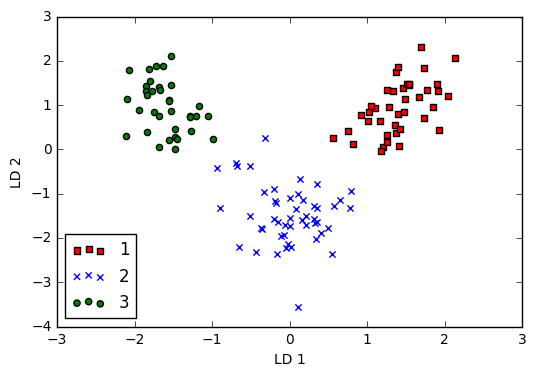

In [22]:
# 標準化したトレーニングデータに変換行列をかける
X_train_lda = X_train_std.dot(w)

colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
# クラスラベル、点の色、点の種類の組み合わせからなるリストを生成してプロット
for label, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==label, 0] * -1, X_train_lda[y_train==label, 1] * -1, c=c, label=label, marker=m)
    
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.show()

### 5.2.4 scikit-learn による LDA

In [23]:
if Version(sklearn_version) < '0.18':
    from sklearn.lda import LDA
else:
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# 次元数を指定して、LDAのインスタンスを生成
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

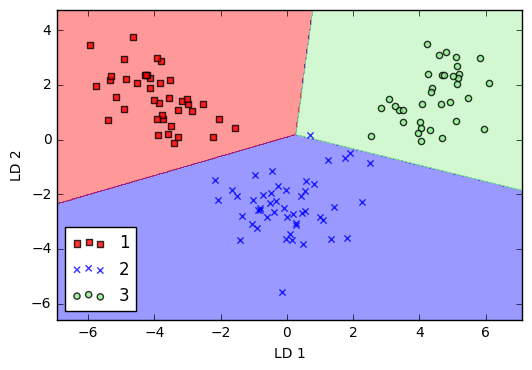

In [24]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_lda, y_train)
# 決定境界をプロット
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.show()

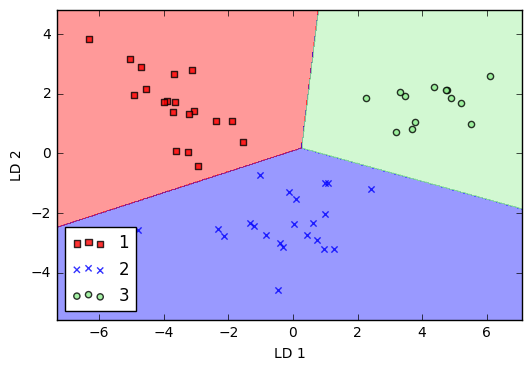

In [25]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.show()

## 5.3 カーネル主成分分析を使った非線形写像

* カーネル化したPCA(kernel PCA)

### 5.3.1 カーネル関数とカーネルトリック

### 5.3.2 Python でカーネル主成分分析を実装する

In [10]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBPカーネルPCAの実装
    
    パラメータ
    ----------
    X: [NumPy ndarray], shape = [n_samples, n_features]
    
    gamma: float
        RBFカーネルのチューニングパラメータ
        
    n_components: int
        返される主成分の個数
        
    戻り値
    ------
    X_pc: [NumPy ndarray], shape = [n_samples, n_features]
        射影されたデータセット
    """
    # M x N 次元のデータセットでペアごとの平方ユークリッド距離を計算
    sq_dists = pdist(X, 'sqeuclidean')
    
    # ペアごとの距離を正方行列に変換
    mat_sq_dists = squareform(sq_dists)
    
    # 対象カーネル行列を計算
    K = exp(-gamma * mat_sq_dists)
    
    # カーネル行列を中心窩
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    # 中心化されたカーネル行列から固有値を取得
    # numpy.eigh はそれらをソート順に返す
    eigvals, eigvecs = eigh(K)
    
    # 上位k個の固有ベクトル(射影されたサンプル)を収集
    X_pc = np.column_stack((eigvecs[:, -i] for i in range(1, n_components + 1)))
    
    return X_pc

例1: 半月形の分離

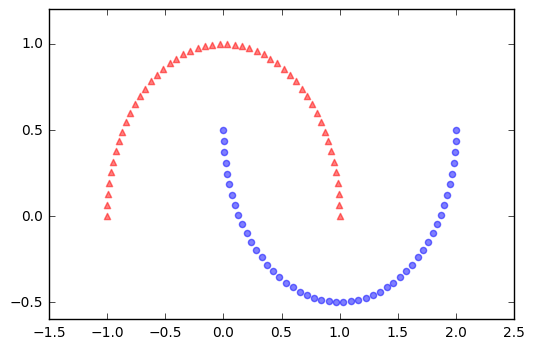

In [11]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

# 2つの半月形データを作成
X, y = make_moons(n_samples=100, random_state=123)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=0.5)
plt.show()

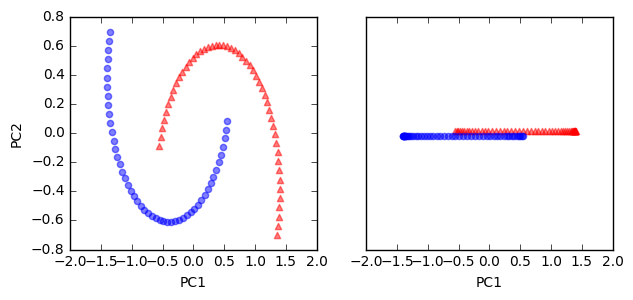

In [12]:
# 標準のPCAを使ってみる
from sklearn.decomposition import PCA
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_spca[y==0, 0], X_spca[y==0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y==1, 0], X_spca[y==1, 1], color='blue', marker='o', alpha=0.5)
# 2番目のグラフ領域に散布図をプロット
ax[1].scatter(X_spca[y==0, 0], np.zeros((50, 1)) + 0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y==1, 0], np.zeros((50, 1)) - 0.02, color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.show()

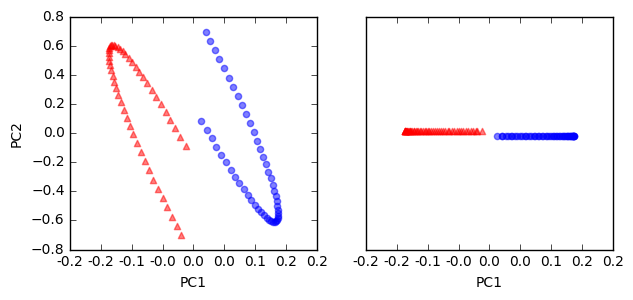

In [14]:
from matplotlib.ticker import FormatStrFormatter
# カーネルPCA関数を使う
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y==0, 0], X_spca[y==0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_spca[y==1, 1], color='blue', marker='o', alpha=0.5)
# 2番目のグラフ領域に散布図をプロット
ax[1].scatter(X_kpca[y==0, 0], np.zeros((50, 1)) + 0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50, 1)) - 0.02, color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
plt.show()

例2: 同心円の分離

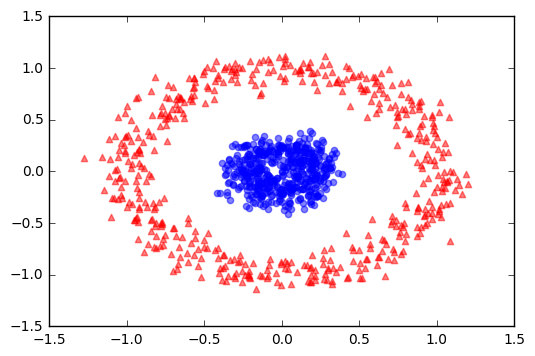

In [17]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

# 同心円用のデータを作成してプロット
X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=0.5)
plt.show()

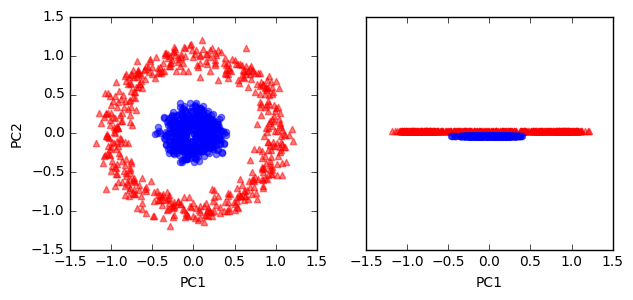

In [18]:
# 標準のPCAを使ってみる
from sklearn.decomposition import PCA
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_spca[y==0, 0], X_spca[y==0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y==1, 0], X_spca[y==1, 1], color='blue', marker='o', alpha=0.5)
# 2番目のグラフ領域に散布図をプロット
ax[1].scatter(X_spca[y==0, 0], np.zeros((500, 1)) + 0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y==1, 0], np.zeros((500, 1)) - 0.02, color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.show()

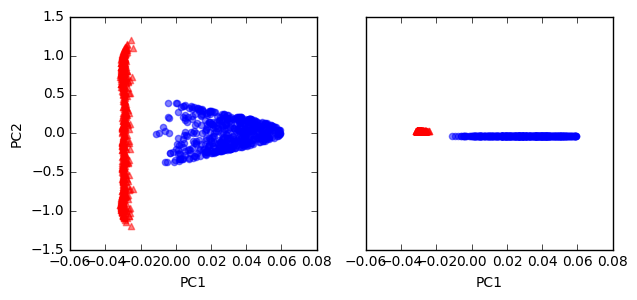

In [21]:
# カーネルPCA関数を使う
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y==0, 0], X_spca[y==0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_spca[y==1, 1], color='blue', marker='o', alpha=0.5)
# 2番目のグラフ領域に散布図をプロット
ax[1].scatter(X_kpca[y==0, 0], np.zeros((500, 1)) + 0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((500, 1)) - 0.02, color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.show()

### 5.3.3 新しいデータ点を射影する

### 5.3.34 scikit-learnのカーネル主成分分析

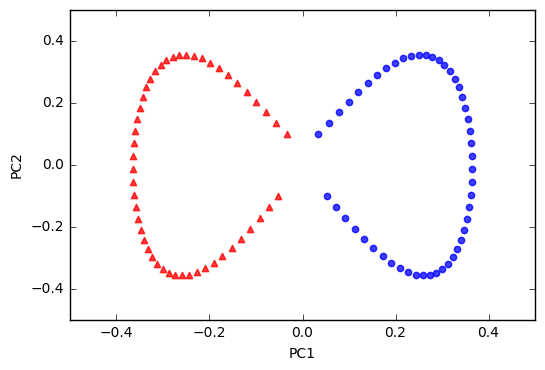

In [25]:
from sklearn.decomposition import KernelPCA
X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plt.scatter(X_skernpca[y==0, 0], X_skernpca[y==0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y==1, 0], X_skernpca[y==1, 1], color='blue', marker='o', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()